In [1291]:

import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE

data_water = pd.read_csv("../data/water_quality_prediction_data/water_potability.csv")
data_ori = data_water.copy()

In [1292]:
data_water.isnull().sum()/len(data_water)

ph                 0.149878
Hardness           0.000000
Solids             0.000000
Chloramines        0.000000
Sulfate            0.238400
Conductivity       0.000000
Organic_carbon     0.000000
Trihalomethanes    0.049451
Turbidity          0.000000
Potability         0.000000
dtype: float64

In [1293]:
data_water.duplicated().sum()

0

In [1294]:
target = 'Potability'
missing = 'Sulfate'
X = data_water.drop(columns= [target ,missing])
y = data_water[target]

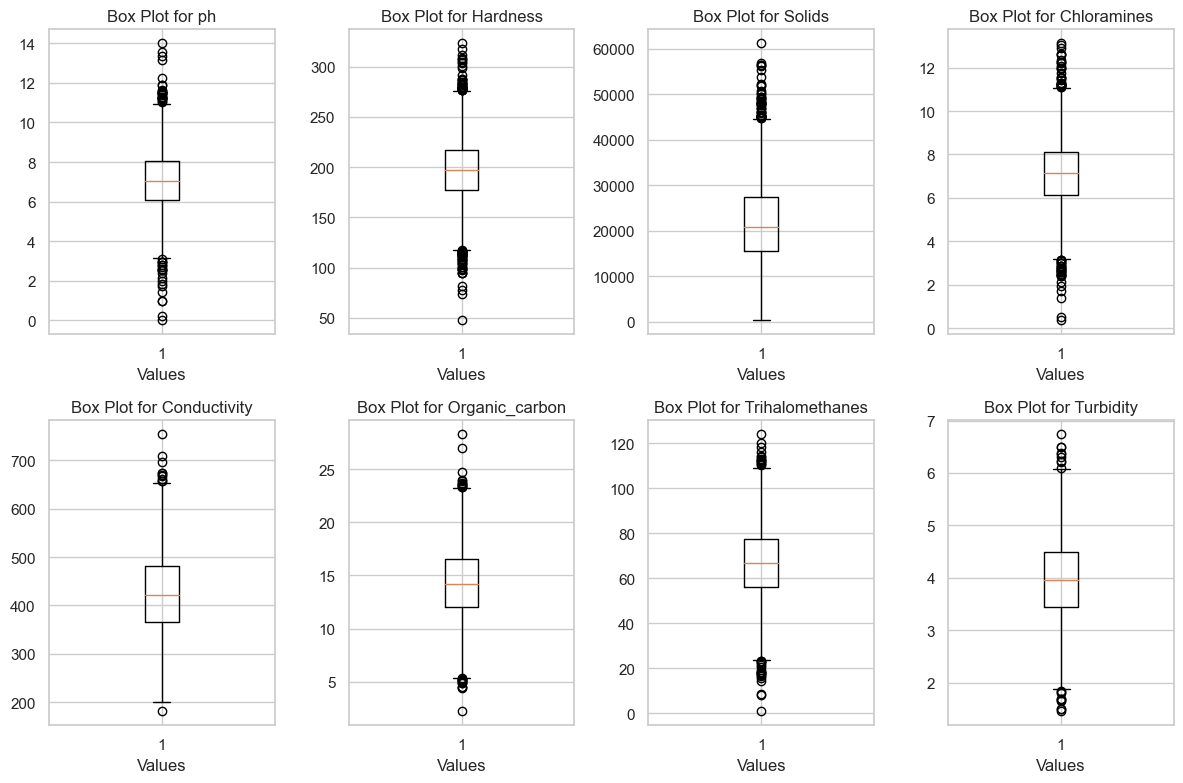

In [1295]:
# Set the figure size for the subplots
plt.figure(figsize=(12,8))

# Iterate through the columns and create individual box plots
for i, column in enumerate(X.columns, 1):
    plt.subplot(2, len(X.columns) //2, i)  # Create a subplot for each column
    plt.boxplot(X[column].dropna())
    plt.title(f'Box Plot for {column}')
    plt.xlabel('Values')
    plt.ylabel('')

plt.tight_layout()  # Adjust subplot spacing

plt.show()


In [1296]:
def remove_outlier(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Create a mask for all columns -> boolean dataframe
    mask = ((data >= lower_bound) & (data <= upper_bound))
    mask[[target, missing]] = True

    # Apply the mask to filter the rows in the original DataFrame
    filtered_data = data[mask.all(axis=1)]

    return filtered_data

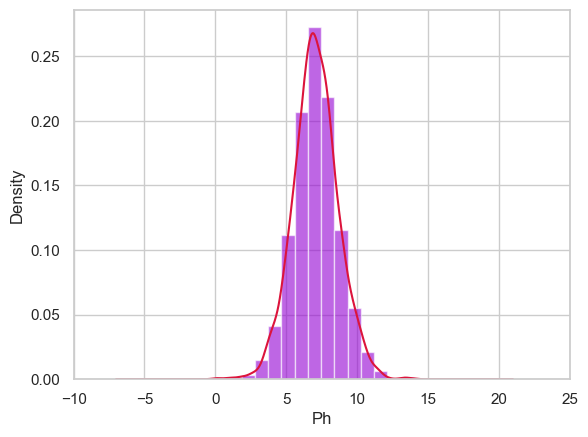

In [1297]:
ax = data_water["ph"].hist(bins=15, density=True, stacked=True, color='darkviolet', alpha=0.6)
data_water["ph"].plot(kind='density', color='crimson')
ax.set(xlabel='Ph')
plt.xlim(-10,25)

plt.show()

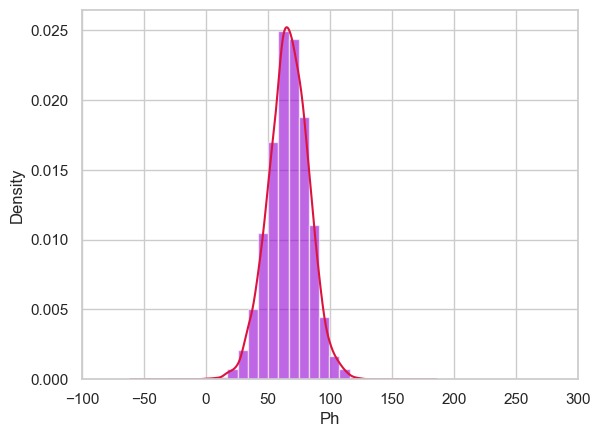

In [1298]:
ax = data_water["Trihalomethanes"].hist(bins=15, density=True, stacked=True, color='darkviolet', alpha=0.6)
data_water["Trihalomethanes"].plot(kind='density', color='crimson')
ax.set(xlabel='Ph')
plt.xlim(-100, 300)

plt.show()

In [1299]:
# fill missing value with mean valuue of each feature

mean_ph = data_water['ph'].mean(skipna= True)
mean_tri = data_water['Trihalomethanes'].mean(skipna = True)
data_water['ph'].fillna(mean_ph, inplace = True)
data_water['Trihalomethanes'].fillna(mean_tri, inplace= True)

In [1300]:
data_water1 = remove_outlier(data_water)

X = data_water1.drop(columns= [target ,missing])
y = data_water1[target]

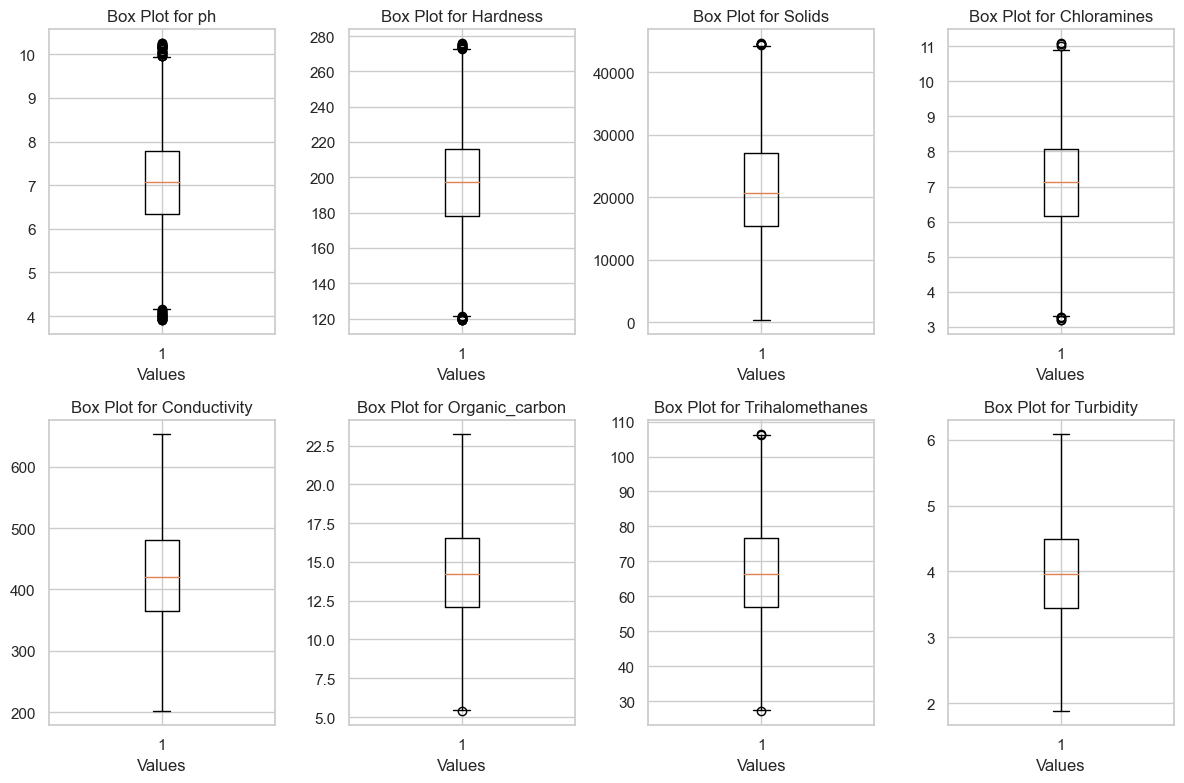

In [1301]:
# Set the figure size for the subplots
plt.figure(figsize=(12,8))

# Iterate through the columns and create individual box plots
for i, column in enumerate(X.columns, 1):
    plt.subplot(2, len(X.columns) //2, i)  # Create a subplot for each column
    plt.boxplot(X[column])
    plt.title(f'Box Plot for {column}')
    plt.xlabel('Values')
    plt.ylabel('')

plt.tight_layout()  # Adjust subplot spacing

plt.show()


In [1302]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33)

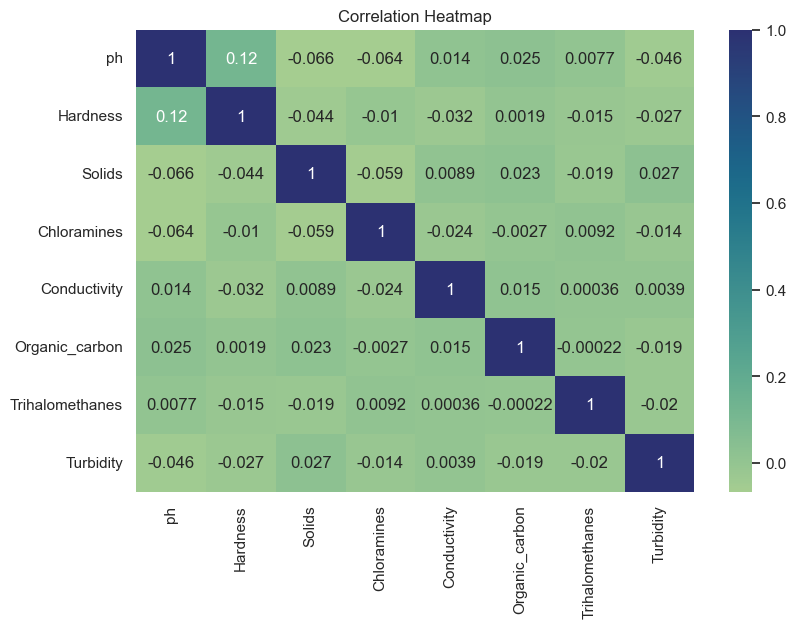

In [1343]:
# Correlation heatmap


plt.figure(figsize=(9, 6))
sns.heatmap(X.corr(), annot=True, cmap='crest')
plt.title('Correlation Heatmap')

plt.show()

In [1304]:
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_std, columns=X_train.columns)

round(X_train_scaled.describe(),2)



,ph,Hardness,Solids,Chloramines,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
count,2161.00,2161.00,2161.00,2161.00,2161.00,2161.00,2161.00,2161.00
mean,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.60,-2.66,-2.62,-2.72,-2.67,-2.83,-2.66,-2.71
25%,-0.61,-0.64,-0.75,-0.67,-0.76,-0.68,-0.66,-0.69
50%,0.01,0.02,-0.12,-0.01,-0.06,-0.04,-0.01,-0.02
75%,0.61,0.66,0.67,0.66,0.70,0.69,0.69,0.70
max,2.63,2.69,2.86,2.73,2.81,2.72,2.68,2.73


In [1336]:
lgr  = LogisticRegression()
lgr.fit(X_train_scaled, y_train)
a = lgr.predict_proba(X_train_scaled)


In [1305]:
# first check with  logistic regression on standard scaled data
lgr  = LogisticRegression()
lgr.fit(X_train_scaled, y_train)
y_pred_lg = lgr.predict(X_test_scaled)
print('Accuracy score for Logistic regression on standard scaled data: ', accuracy_score(y_test, y_pred_lg))
print('Precision score for Logistic regression on standard scaled data: ', precision_score(y_test, y_pred_lg))
print()
print(confusion_matrix(y_test, y_pred_lg))
print()
print(classification_report(y_test, y_pred_lg))

Accuracy score for Logistic regression on standard scaled data:  0.5977808599167822
Precision score for Logistic regression on standard scaled data:  0.0

[[431   0]
 [290   0]]

              precision    recall  f1-score   support

           0       0.60      1.00      0.75       431
           1       0.00      0.00      0.00       290

    accuracy                           0.60       721
   macro avg       0.30      0.50      0.37       721
weighted avg       0.36      0.60      0.45       721



c:\Users\leedh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leedh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leedh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

0.5839526059564719


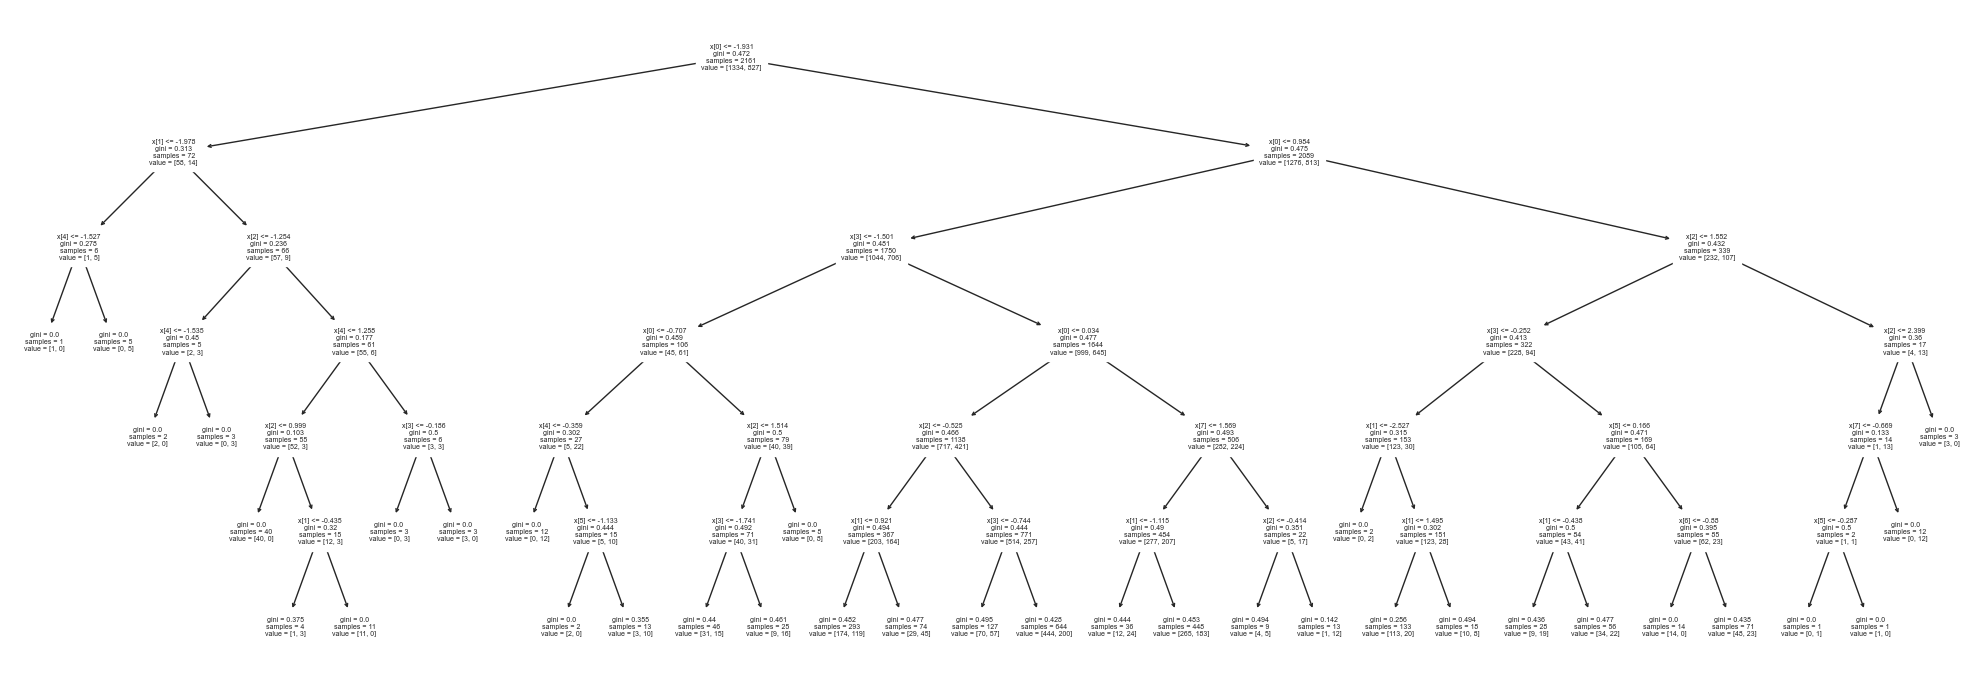

In [1306]:
# build pipeline consturction for analysis

pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state = 33, max_depth=6))
pipe.fit(X_train, y_train)  # apply scaling on training data
pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.

print(cross_val_score(pipe ,X, y, cv=30).mean())

plt.figure(figsize=(20,7))
# print(pipe.get_params())
tree.plot_tree(pipe.named_steps['decisiontreeclassifier'], fontsize= 5)
plt.tight_layout()  # Adjust subplot spacing
plt.show()


In [1307]:
print('Shape of X_train: ', X_train.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of y_test: ', y_test.shape)

Shape of X_train:  (2161, 8)
Shape of X_test:  (721, 8)
Shape of y_train:  (2161,)
Shape of y_test:  (721,)


In [1308]:
# build pipeline consturction for analysis

pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state = 33))
# print(pipe.get_params())


In [1309]:
model = pipe.fit(X_train, y_train)  # apply scaling on training data
# print(pipe.get_params())

# pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.


In [1310]:

y_pred = model.predict(X_test)


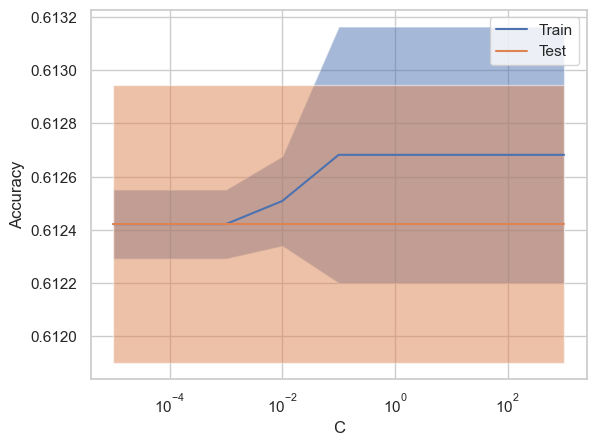

In [1311]:
from sklearn.model_selection import ValidationCurveDisplay


_ = ValidationCurveDisplay.from_estimator(
    LogisticRegression(),
    X,
    y,
    param_name="C",
    param_range=np.geomspace(1e-5, 1e3, num=9),
    score_type="both",
    score_name="Accuracy",
)

<Figure size 3500x1000 with 0 Axes>

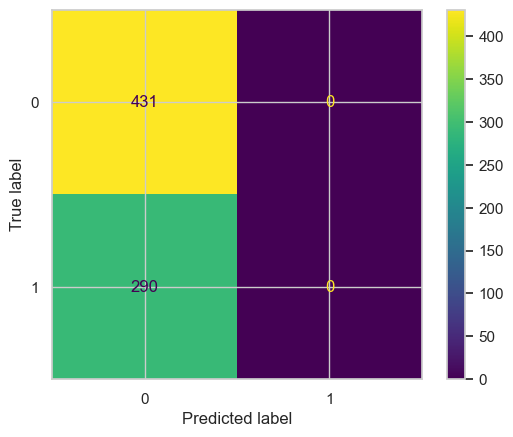

In [1312]:
plt.figure(figsize=(35, 10))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

Text(0.5, 427.9555555555555, 'Predicted label')

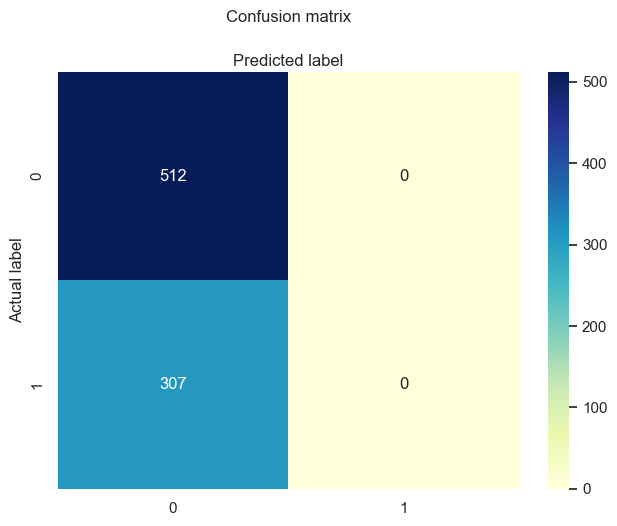

In [1313]:

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Text(0.5,257.44,'Predicted label');

In [1314]:
from sklearn.metrics import classification_report
target_names = ['1', '0']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           1       0.60      1.00      0.75       431
           0       0.00      0.00      0.00       290

    accuracy                           0.60       721
   macro avg       0.30      0.50      0.37       721
weighted avg       0.36      0.60      0.45       721



c:\Users\leedh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leedh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leedh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [1315]:
# y_pred_proba = model.predict_proba(X_test)[::,1]
# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
# auc = metrics.roc_auc_score(y_test, y_pred_proba)
# plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
# plt.legend(loc=4)
# plt.show()